<a href="https://colab.research.google.com/github/bukhtiarhaider/CE888/blob/main/IHDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install econml

In [49]:
!pip install xgboost

In [50]:
%matplotlib inline
from xgboost import XGBRegressor, XGBClassifier
from econml.metalearners import XLearner
from econml.dr import  DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from google.colab import files

In [51]:
# Load the data
dfraw = pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.csv')
dfraw.head() # Just taking a quick look at the data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,2.747986,4.265591


# **DATA CLEANING**


Categorical Encoding

In [52]:
class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)

In [53]:
cat_features = ["x4"]

encoder = OneHotEncoderCategoricalFeatures(cat_features)
df = encoder.transform(dfraw)

Train/Test Split

In [54]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['t'], random_state = 10)

Over Sampling


In [55]:
smote_oversample = SMOTE()
t = df_train['t']
print(Counter(t))
df_train = df_train.drop('t', axis = 1)
df_train, t = smote_oversample.fit_resample(df_train, t)
print(Counter(t))

Counter({0.0: 486, 1.0: 111})
Counter({0.0: 486, 1.0: 486})


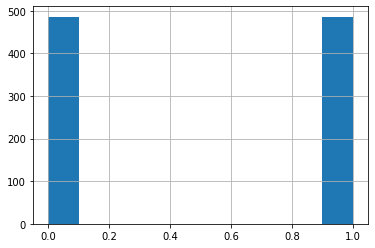

In [56]:
df_train['t'] = t
df_train['t'].hist(bins=10)

In [57]:
y_train = df_train['yf']
ycf_train = df_train['ycf']
ite_train = df_train['ite']
t_train = df_train['t']
x_train = df_train.drop(['t', 'yf', 'ycf', 'ite'], axis = 1)

y_test = df_test['yf']
ycf_test = df_test['ycf']
ite_test = df_test['ite']
t_test = df_test['t']
x_test = df_test.drop(['t', 'yf', 'ycf', 'ite'], axis = 1)

In [58]:
print((len(ite_train)*np.mean(ite_train) + len(ite_test)*np.mean(ite_test))/(len(ite_train)+len(ite_test)))
print(np.mean(dfraw['ite']))
print(np.mean(ite_test))

4.011262444935808
4.016066896118339
3.9807528374455616


Feature Selection

In [59]:
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select = 25)
fit = rfe.fit(pd.concat((pd.concat((x_train, x_test), axis = 0), pd.concat((t_train, t_test), axis = 0)), axis = 1), pd.concat((y_train, y_test), axis = 0))
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))


Num Features: 25
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True False False  True  True
  True False  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 4 5 1 1 1 2 1 1 1]


In [60]:
features = []
for i in range (len(fit.support_)):
  if(fit.ranking_[i]==1):
    #Retrieve selected column names
    col = pd.concat((x_train, t_train), axis = 1).columns[i]
    if(col!='t'):
      features.append(col)
print("Selected Features: ", features)


Selected Features:  ['x1', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x19', 'x20', 'x21', 'x24', 'x25', 'x4_-0.879605988141577', 'x4_1.20301104241867', 'x4_2.24431955769879']


In [61]:
x_train = x_train[features]
x_test = x_test[features]
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
ycf_train = ycf_train.values.reshape(-1, 1)
ycf_test = ycf_test.values.reshape(-1, 1)
t_train = t_train.values.reshape(-1, 1)
t_test = t_test.values.reshape(-1, 1)

Train/Test Split

In [62]:
#x_train, x_test, t_train, t_test, y_train, y_test, ycf_train, ycf_test, ite_train, ite_test = train_test_split(x, t, y, ycf, ite, test_size=0.2, stratify=t, random_state = 0)
folds = 10
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

**SIMPLE REGRESSION**
TODO: CrossValidation

In [63]:
scores = []

xt_train = np.concatenate((x_train, t_train), axis = 1)
ytrainflat = y_train.flatten()
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(xt_train, ytrainflat)

for train_index, test_index in skf.split(xt_train, t_train):
  gbr = GradientBoostingRegressor(n_estimators = 1000, min_samples_split=15, min_samples_leaf=15, random_state=0)
  #gbr = RandomForestRegressor(n_estimators = 1000, min_samples_split=15, min_samples_leaf=15)
  #gbr = XGBRegressor(max_depth = 6)
  xttrain, xttest = xt_train[train_index], xt_train[test_index]
  ytrain, ytest = ytrainflat[train_index], ytrainflat[test_index]
  xtrain, xtest = x_train[train_index], x_train[test_index]
  ttrain, ttest = t_train[train_index], t_train[test_index]

  gbr.fit(xttrain, ytrain)
  #Test with t = 0
  xt0_test = np.concatenate((xtest, np.zeros_like(ttest)), axis=1)
  rf_y0_test = gbr.predict(xt0_test)
  #Test with t = 1
  xt1_test = np.concatenate((xtest, np.ones_like(ttest)), axis=1)
  rf_y1_test = gbr.predict(xt1_test)
  #ITE
  rf_te_test = rf_y1_test - rf_y0_test
  scores.append(rf_te_test.mean())
  print(rf_te_test.mean())

print(np.mean(scores))

gbr = GradientBoostingRegressor(n_estimators = 1000, min_samples_split=15, min_samples_leaf=15, random_state=0)
#gbr = RandomForestRegressor(n_estimators = 400, min_samples_split=15, min_samples_leaf=15)
#gbr = XGBRegressor(max_depth = 6)

gbr.fit(xt_train, ytrainflat)
#Test with t = 0
xt0_test = np.concatenate((x_test, np.zeros_like(t_test)), axis=1)
rf_y0_test = gbr.predict(xt0_test)
#Test with t = 1
xt1_test = np.concatenate((x_test, np.ones_like(t_test)), axis=1)
rf_y1_test = gbr.predict(xt1_test)
#ITE
rf_te_test = rf_y1_test - rf_y0_test
print(rf_te_test.mean())

3.8457935573588804
4.126121657322971
3.823462440187429
3.9638130799276734
3.9481455343943246
3.998147199504657
3.892733468163085
3.9511656064363825
3.797541656750713
3.786495515637452
3.9133419715683573
3.8557326804735506


**IPW Regression**
TODO: CrossValidation

In [64]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
  wi = ti/ptx + (1-ti)/(1-ptx)
  return wi

In [65]:
scores = []

subsamp = 0.88
estimators = 1000

for train_index, test_index in skf.split(xt_train, t_train):
  prop_gbr = GradientBoostingClassifier(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=0)
  xtrain, xtest = x_train[train_index], x_train[test_index]
  ttrain, ttest = t_train[train_index], t_train[test_index]
  xttrain, xttest = xt_train[train_index], xt_train[test_index]
  ytrain, ytest = ytrainflat[train_index], ytrainflat[test_index]

  weights = get_ps_weights(prop_gbr, xtrain, ttrain)

  gbr_ipsw = GradientBoostingRegressor(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=0)

  gbr_ipsw.fit(xttrain, ytrain, sample_weight=weights)

  gbr_ipsw_y0_test = gbr_ipsw.predict(np.concatenate((xtest, np.zeros_like(ttest)), axis = 1))
  gbr_ipsw_y1_test = gbr_ipsw.predict(np.concatenate((xtest, np.ones_like(ttest)), axis = 1))

  gbr_ipsw_te_test = gbr_ipsw_y1_test - gbr_ipsw_y0_test

  scores.append(gbr_ipsw_te_test.mean())
  print(gbr_ipsw_te_test.mean())

print(np.mean(scores))
prop_clf = GradientBoostingClassifier(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=0)
weights = get_ps_weights(prop_clf, x_train, t_train)

rf_ipsw = GradientBoostingRegressor(n_estimators=estimators, min_samples_split=15, min_samples_leaf=15, subsample=subsamp, random_state=0)

rf_ipsw.fit(xt_train, y_train.flatten(), sample_weight=weights)

rf_ipsw_y0_test = rf_ipsw.predict(np.concatenate((x_test, np.zeros_like(t_test)), axis = 1))
rf_ipsw_y1_test = rf_ipsw.predict(np.concatenate((x_test, np.ones_like(t_test)), axis = 1))

rf_ipsw_te_test = rf_ipsw_y1_test - rf_ipsw_y0_test

rf_ipsw_te_test.mean()

3.885912634086854
4.118338952656245
3.8545407667507976
3.967548231367655
4.000801191130844
4.019636807835653
3.899308524871887
3.96879484181728
3.7693526659696666
3.807772865728023
3.929200748221491


**XLearner**
TODO: CrossValidation

In [66]:
from pandas.compat.numpy.function import STAT_DDOF_FUNC_DEFAULTS
scores = []

estimators = 1000
subsamp = 1
state = 10
split = 15
leaf = 15



for train_index, test_index in skf.split(xt_train, t_train):
  #xl = XLearner(models=GradientBoostingRegressor(n_estimators=estimators, subsample=subsamp, min_samples_split=split, min_samples_leaf=leaf, random_state=state), propensity_model=GradientBoostingClassifier(n_estimators=estimators, subsample=subsamp, min_samples_split=split, min_samples_leaf=leaf, random_state=state))
  xl = DRLearner(model_regression=GradientBoostingRegressor(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_propensity=RandomForestClassifier(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_final=LassoCV(cv=5), random_state = state)

  xtrain, xtest = x_train[train_index], x_train[test_index]
  ttrain, ttest = t_train[train_index], t_train[test_index]
  ytrain, ytest = ytrainflat[train_index], ytrainflat[test_index]

  xl.fit(ytrain, ttrain.flatten(), X=xtrain)
  xl_te_test = xl.effect(xtest)
  scores.append(xl_te_test.mean())
  print(xl_te_test.mean())

#xl = XLearner(models=GradientBoostingRegressor(n_estimators=estimators, subsample=subsamp, min_samples_split=split, min_samples_leaf=leaf, random_state=state), propensity_model=GradientBoostingClassifier(n_estimators=estimators, subsample=subsamp, min_samples_split=split, min_samples_leaf=leaf, random_state=state))
xl = DRLearner(model_regression=GradientBoostingRegressor(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_propensity=RandomForestClassifier(n_estimators=estimators, min_samples_leaf = leaf, min_samples_split=split,  random_state=state), model_final=LassoCV(cv=5), random_state = state)
xl.fit(ytrainflat, t_train.flatten(), X=x_train)

xl_te_test = xl.effect(x_test)
print(np.mean(scores))
xl_te_test.mean()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


3.8587868390133435


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


4.0103765317035585


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


3.859747964193421


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


4.0062593633587396


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


4.024814419872229


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


3.9265309709779674


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


3.9466396678929034


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


3.939707726431243


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


3.7123616499723266


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


3.894955263292008
3.918018039670774


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [67]:
# Error on ATE
# Use our 'abs_ate' function, true ITEs and predicted ITEs to get the measurements.
rf_ate_test = np.abs(np.mean(rf_te_test) - np.mean(dfraw['ite']))
rf_ipsw_ate_test = np.abs(np.mean(rf_ipsw_te_test) - np.mean(dfraw['ite']))
xl_ate_test = np.abs(np.mean(xl_te_test) - np.mean(dfraw['ite']))

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test = np.sqrt(np.mean(np.square(rf_te_test - np.full_like(rf_te_test, np.mean(dfraw['ite']), dtype=np.double))))
rf_ipsw_pehe_test = np.sqrt(np.mean(np.square(rf_ipsw_te_test - np.full_like(rf_ipsw_te_test, np.mean(dfraw['ite']), dtype=np.double))))
xl_pehe_test = np.sqrt(np.mean(np.square(xl_te_test - np.full_like(xl_te_test, np.mean(dfraw['ite']), dtype=np.double))))

In [82]:
results = []
results.append(['SL', rf_ate_test, rf_pehe_test])
results.append(['TL', rf_ipsw_ate_test, rf_ipsw_pehe_test])
results.append(['DR-L', xl_ate_test, xl_pehe_test])

cols = ['Method', 'ATE test', 'PEHE test']

res = pd.DataFrame(results, columns=cols)
res

,Method,ATE test,PEHE test
0,SL,0.160334,0.981443
1,TL,0.116833,0.955747
2,DR-L,0.021413,0.785015


In [69]:
features.append('t')
print(features)

['x1', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x19', 'x20', 'x21', 'x24', 'x25', 'x4_-0.879605988141577', 'x4_1.20301104241867', 'x4_2.24431955769879', 't']


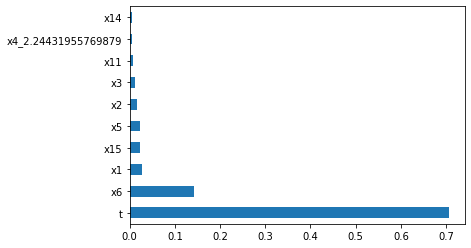

In [70]:

feat_importances = pd.Series(gbr.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')

In [71]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [84]:
rf_ate_bounds = mean_ci(rf_te_test)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_test)
xl_ate_bounds = mean_ci(xl_te_test)

results = []
results.append(['SL', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['TL', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['DR-L', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,SL,3.855733,3.698990,4.012475
1,TL,3.899234,3.745676,4.052791
2,DR-L,4.037480,3.910448,4.164512


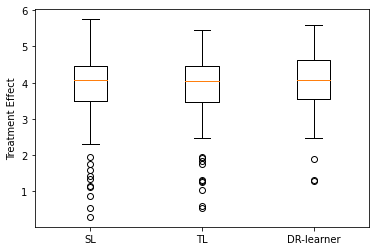

In [83]:
plt.figure()
plt.boxplot([rf_te_test, rf_ipsw_te_test, xl_te_test.flatten()], labels=['SL', 'TL', 'DR-learner'])
plt.ylabel('Treatment Effect')

plt.show()

In [80]:
print(len(rf_te_test))
print(x_test.shape)
index = df_train.columns.get_loc('x6')

150
(150, 24)


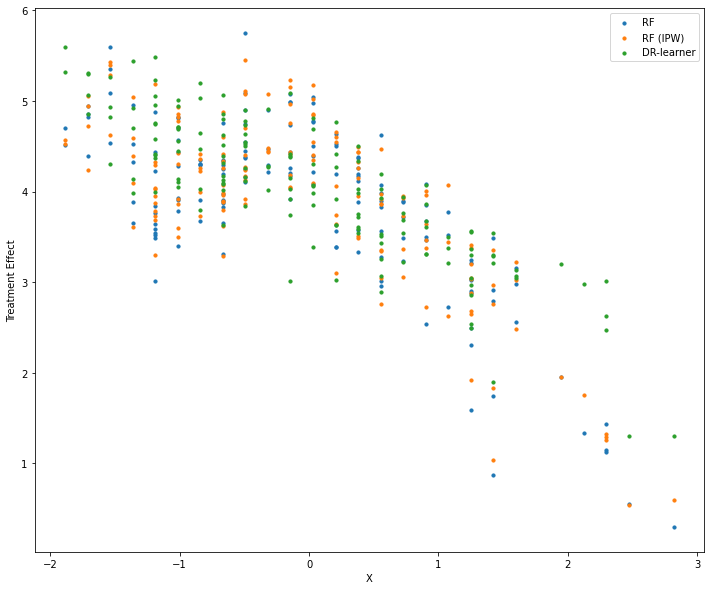

In [81]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test[:,index], rf_te_test, label="RF", s=m_size)
plt.scatter(x_test[:,index], rf_ipsw_te_test, label="RF (IPW)", s=m_size)
plt.scatter(x_test[:,index], xl_te_test, label="DR-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

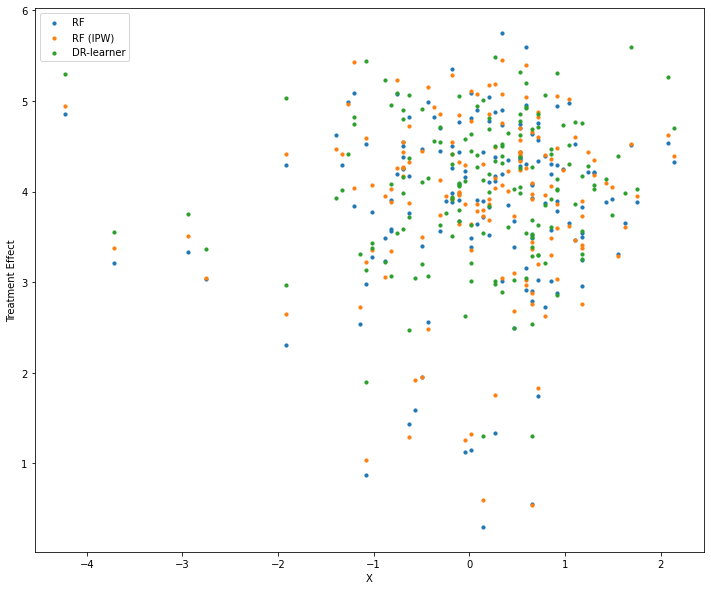

In [79]:
index = df_train.columns.get_loc('x5')
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test[:,index], rf_te_test, label="RF", s=m_size)
plt.scatter(x_test[:,index], rf_ipsw_te_test, label="RF (IPW)", s=m_size)
plt.scatter(x_test[:,index], xl_te_test, label="DR-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

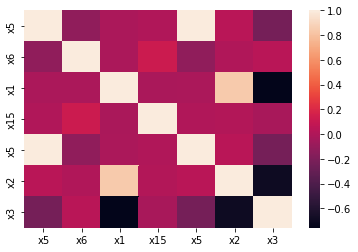

In [77]:
import seaborn as sns
features2 = ['x5', 'x6', 'x1', 'x15', 'x5', 'x2', 'x3']
sns.heatmap(dfraw[features2].corr())